In [1]:
import torch
import torch.nn.functional as F
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

2023-06-22 08:40:14.980323: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 08:40:15.552233: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
device = torch.device("cuda:0")
torch.set_default_device(device)

In [3]:
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)

(X_train, y_train), (X_test, y_test) = load_data('data/mnist.npz')

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

In [6]:
X_train = torch.from_numpy(X_train / 255)
X_test = torch.from_numpy(X_test / 255)

In [7]:
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [8]:
X_train = X_train.cuda()
y_train = y_train.cuda()
X_test = X_test.cuda()
y_test = y_test.cuda()

In [13]:
n_hidden = 64

W1 = torch.randn((784, n_hidden)).double()
b1 = torch.randn(n_hidden).double()
W2 = torch.randn((n_hidden, 10)).double()
b2 = torch.randn(10).double()
params = [W1, b1, W2, b2]

for param in params:
    param.requires_grad = True

In [15]:
from distutils.sysconfig import get_python_lib
print(get_python_lib())

/home/nickt/anaconda3/envs/AI/lib/python3.11/site-packages


In [14]:
steps = 50000
batch_size = 32
lossi = []

for i in range(steps):
    
    ix = torch.randint(0, X_train.shape[0], (batch_size, ))
    Xb, Yb = X_train[ix], y_train[ix]
    
    hpreact = Xb @ W1 + b1
    h = torch.tanh(hpreact)
    opreact = h @ W2 + b2
    sm = torch.nn.Softmax(dim=1)
    o = sm(opreact)
    loss = F.cross_entropy(o, Yb)
    
    for p in params:
        p.grad = None
    loss.backward()
    
    lr = 0.1 #if i < steps // 2 else 0.01  # switches learning rate at 100000 steps in order to be more accurate
    for p in params:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{steps:7d}: {loss.item():.4f}') # prints loss every 10000 steps
    lossi.append(loss.log10().item())

      0/  50000: 2.3076
  10000/  50000: 1.8698
  20000/  50000: 1.7570
  30000/  50000: 1.5319
  40000/  50000: 1.5385


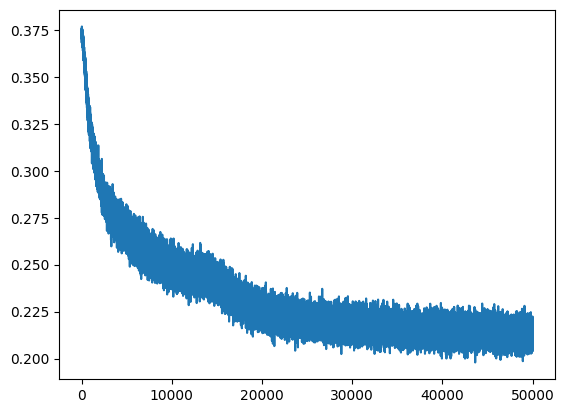

In [11]:
plt.plot(lossi)